# pix2pix: Image-to-image translation with a conditional GAN

## Import TensorFlow and other libraries

In [22]:
import tensorflow as tf
import imutils
import os
import pathlib
import time
import datetime
import cv2
import numpy as np
import pydot
import graphviz
import glob

from matplotlib import pyplot as plt
from IPython import display
from tqdm import tqdm
from sklearn.metrics import jaccard_score
from tensorflow.keras import Model

In [23]:
BATCH_SIZE = 32
image_size = 256
LAMBDA = 100
OUTPUT_CHANNELS = 3 #number of classes

In [24]:
workspace_path = '/home/ahmedf/Downloads/'
train_path = '/home/ahmedf/Downloads/Training/' 
test_path = '/home/ahmedf/Downloads/Test/'
results_path = '/home/ahmedf/Downloads/seg_results2/'

In [25]:
sample_image = tf.io.read_file(train_path + 'ISIC_0014919.jpg')
sample_image = tf.io.decode_jpeg(sample_image)
sample_mask = tf.io.read_file(train_path + 'ISIC_0014919_segmentation.png')
sample_mask = tf.io.decode_png(sample_mask)
mask_rgb = tf.image.grayscale_to_rgb(sample_mask)
print(sample_image.shape, sample_mask.shape)

(4459, 6708, 3) (4459, 6708, 1)


Text(0.5, 1.0, 'Mask_rgb')

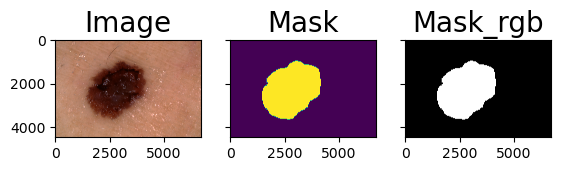

In [26]:
fig, axs = plt.subplots(1, 3, sharey=True)
axs[0].imshow(sample_image)
axs[0].set_title("Image", fontdict={'fontsize': 20, 'fontweight': 'medium'})
axs[1].imshow(sample_mask)
axs[1].set_title("Mask", fontdict={'fontsize': 20, 'fontweight': 'medium'})
axs[2].imshow(mask_rgb)
axs[2].set_title("Mask_rgb", fontdict={'fontsize': 20, 'fontweight': 'medium'})

You need to separate real building facade images from the architecture label images—all of which will be of size `256 x 256`.

Define a function that loads image files and outputs two image tensors:

In [27]:
def load(img_url):
    # Read and decode an image file to a uint8 tensor
    image = tf.io.read_file(img_url)
    image = tf.io.decode_jpeg(image)

    mask = tf.io.read_file(tf.strings.split(img_url, sep='.')[0] + '_segmentation.png')
    mask = tf.io.decode_png(mask)

    # Convert both images to float32 tensors
    input_image = tf.cast(image, tf.float32)
    real_image = tf.cast(mask, tf.float32)
    real_image = tf.image.grayscale_to_rgb(real_image)

    return input_image, real_image

In [28]:
def load_gen(img_url):
    # Read and decode an image file to a uint8 tensor
    image = tf.io.read_file(img_url)
    image = tf.io.decode_jpeg(image)

    # Convert both images to float32 tensors
    input_image = tf.cast(image, tf.float32)

    return input_image

Plot a sample of the input (architecture label image) and real (building facade photo) images:

As described in the [pix2pix paper](https://arxiv.org/abs/1611.07004){:.external}, you need to apply random jittering and mirroring to preprocess the training set.

Define several functions that:

1. Resize each `256 x 256` image to a larger height and width—`286 x 286`.
2. Randomly crop it back to `256 x 256`.
3. Randomly flip the image horizontally i.e. left to right (random mirroring).
4. Normalize the images to the `[-1, 1]` range.

Data augmentation 

In [29]:
def resize(input_image, real_image, height, width):
    input_image = tf.image.resize(input_image, [height, width],
                                method=tf.image.ResizeMethod.NEAREST_NEIGHBOR)
    real_image = tf.image.resize(real_image, [height, width],
                                method=tf.image.ResizeMethod.NEAREST_NEIGHBOR)

    return input_image, real_image

In [30]:
def resize_gen(input_image, height, width):
    input_image = tf.image.resize(input_image, [height, width],
                                method=tf.image.ResizeMethod.NEAREST_NEIGHBOR)
    return input_image

In [31]:
def random_crop(input_image, real_image):
    stacked_image = tf.stack([input_image, real_image], axis=0)
    cropped_image = tf.image.random_crop(stacked_image, size=[2, image_size, image_size, 3])

    return cropped_image[0], cropped_image[1]

In [32]:
def random_crop_gen(input_image):
    return tf.image.random_crop(input_image, size=[2, image_size, image_size, 3])

In [33]:
# Normalizing the images to [-1, 1]
def normalize(input_image, real_image):
    input_image = (input_image / 127.5) - 1
    real_image = (real_image / 127.5) - 1

    return input_image, real_image

In [34]:
# Normalizing the images to [-1, 1]
def normalize_gen(input_image):
    return (input_image / 127.5) - 1

In [35]:
@tf.function()
def random_jitter(input_image, real_image):
    # Resizing to 286x286
    input_image, real_image = resize(input_image, real_image, image_size+30, image_size+30)

    # Random cropping back to 256x256
    input_image, real_image = random_crop(input_image, real_image)

    if tf.random.uniform(()) > 0.5:
        # Random mirroring
        input_image = tf.image.flip_left_right(input_image)
        real_image = tf.image.flip_left_right(real_image)

    return input_image, real_image

In [36]:
@tf.function()
def random_jitter_gen(input_image):
    # Resizing to 286x286
    input_image = resize(input_image, image_size+30, image_size+30)

    # Random cropping back to 256x256
    input_image = random_crop(input_image)

    if tf.random.uniform(()) > 0.5:
        # Random mirroring
        input_image = tf.image.flip_left_right(input_image)

    return input_image

Having checked that the loading and preprocessing works, let's define a couple of helper functions that load and preprocess the training and test sets:

In [37]:
def load_image_train(image_file):
    input_image, real_image = load(image_file)
    input_image, real_image = resize(input_image, real_image, image_size, image_size)
    input_image, real_image = random_jitter(input_image, real_image)
    input_image, real_image = normalize(input_image, real_image)

    return input_image, real_image

In [38]:
def load_image_test(image_file):
    input_image, real_image = load(image_file)
    input_image, real_image = resize(input_image, real_image,
                                   image_size, image_size)
    input_image, real_image = normalize(input_image, real_image)

    return input_image, real_image

In [39]:
def load_image_to_generate(image_file):
    input_image = load_gen(image_file)
    input_image = resize_gen(input_image, image_size, image_size)
    input_image = normalize_gen(input_image)

    return input_image

## Build an input pipeline with `tf.data`

In [40]:
train_dataset = tf.data.Dataset.list_files(train_path + '*.jpg')
train_dataset = train_dataset.map(load_image_train)
train_dataset = train_dataset.batch(BATCH_SIZE)

Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module 'gast' has no attribute 'Index'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module 'gast' has no attribute 'Index'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module 'gast' has no attribute 'Index'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `

In [41]:
test_dataset = tf.data.Dataset.list_files(test_path + '*.jpg')
test_dataset = test_dataset.map(load_image_test)
test_dataset = test_dataset.batch(BATCH_SIZE)

## Build the generator

The generator of your pix2pix cGAN is a _modified_ [U-Net](https://arxiv.org/abs/1505.04597){:.external}. A U-Net consists of an encoder (downsampler) and decoder (upsampler). (You can find out more about it in the [Image segmentation](../images/segmentation.ipynb) tutorial and on the [U-Net project website](https://lmb.informatik.uni-freiburg.de/people/ronneber/u-net/){:.external}.)

- Each block in the encoder is: Convolution -> Batch normalization -> Leaky ReLU
- Each block in the decoder is: Transposed convolution -> Batch normalization -> Dropout (applied to the first 3 blocks) -> ReLU
- There are skip connections between the encoder and decoder (as in the U-Net).

Define the downsampler (encoder):

In [42]:
def downsample(filters, size, apply_batchnorm=True):
    initializer = tf.random_normal_initializer(0., 0.02)

    result = tf.keras.Sequential()
    result.add(
      tf.keras.layers.Conv2D(filters, size, strides=2, padding='same',
                             kernel_initializer=initializer, use_bias=False))

    if apply_batchnorm:
        result.add(tf.keras.layers.BatchNormalization())

    result.add(tf.keras.layers.LeakyReLU())

    return result

In [43]:
inp, re = load(train_path + 'ISIC_0013725.jpg')

down_model = downsample(3, 4)

inp_res = tf.image.resize(inp, [image_size, image_size],
                                method=tf.image.ResizeMethod.NEAREST_NEIGHBOR)
down_result = down_model(tf.expand_dims(inp_res, 0))
print (down_result.shape)

2022-12-06 23:20:48.007217: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudnn.so.7


(1, 128, 128, 3)


2022-12-06 23:20:48.662521: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcublas.so.10


Define the upsampler (decoder):

In [44]:
def upsample(filters, size, apply_dropout=False):
    initializer = tf.random_normal_initializer(0., 0.02)

    result = tf.keras.Sequential()
    result.add(
    tf.keras.layers.Conv2DTranspose(filters, size, strides=2,
                                    padding='same',
                                    kernel_initializer=initializer,
                                    use_bias=False))

    result.add(tf.keras.layers.BatchNormalization())

    if apply_dropout:
        result.add(tf.keras.layers.Dropout(0.5))

    result.add(tf.keras.layers.ReLU())

    return result

In [45]:
up_model = upsample(3, 4)
up_result = up_model(down_result)
print (up_result.shape)

(1, 256, 256, 3)


Define the generator with the downsampler and the upsampler:

In [46]:
def Generator():
    inputs = tf.keras.layers.Input(shape=[image_size, image_size, 3])

    down_stack = [
        downsample(64, 4, apply_batchnorm=False),  # (batch_size, 128, 128, 64)
        downsample(128, 4),  
        downsample(256, 4),  
        downsample(512, 4),  
        downsample(512, 4),  
        downsample(512, 4),  
        downsample(512, 4),  
        downsample(512, 4),  
    ]

    up_stack = [
        upsample(512, 4, apply_dropout=True),
        upsample(512, 4, apply_dropout=True),
        upsample(512, 4, apply_dropout=True),
        upsample(512, 4),
        upsample(256, 4),
        upsample(128, 4),
        upsample(64, 4), 
    ]

    initializer = tf.random_normal_initializer(0., 0.02)
    last = tf.keras.layers.Conv2DTranspose(OUTPUT_CHANNELS, 4,
                                         strides=2,
                                         padding='same',
                                         kernel_initializer=initializer,
                                         activation='tanh')  # (batch_size, 256, 256, 3)

    x = inputs

  # Downsampling through the model
    skips = []
    for down in down_stack:
        x = down(x)
        skips.append(x)

    skips = reversed(skips[:-1])

  # Upsampling and establishing the skip connections
    for up, skip in zip(up_stack, skips):
        x = up(x)
        x = tf.keras.layers.Concatenate()([x, skip])

    x = last(x)

    # x_gray = tf.image.rgb_to_grayscale(x)
    return tf.keras.Model(inputs=inputs, outputs=x)

Visualize the generator model architecture:

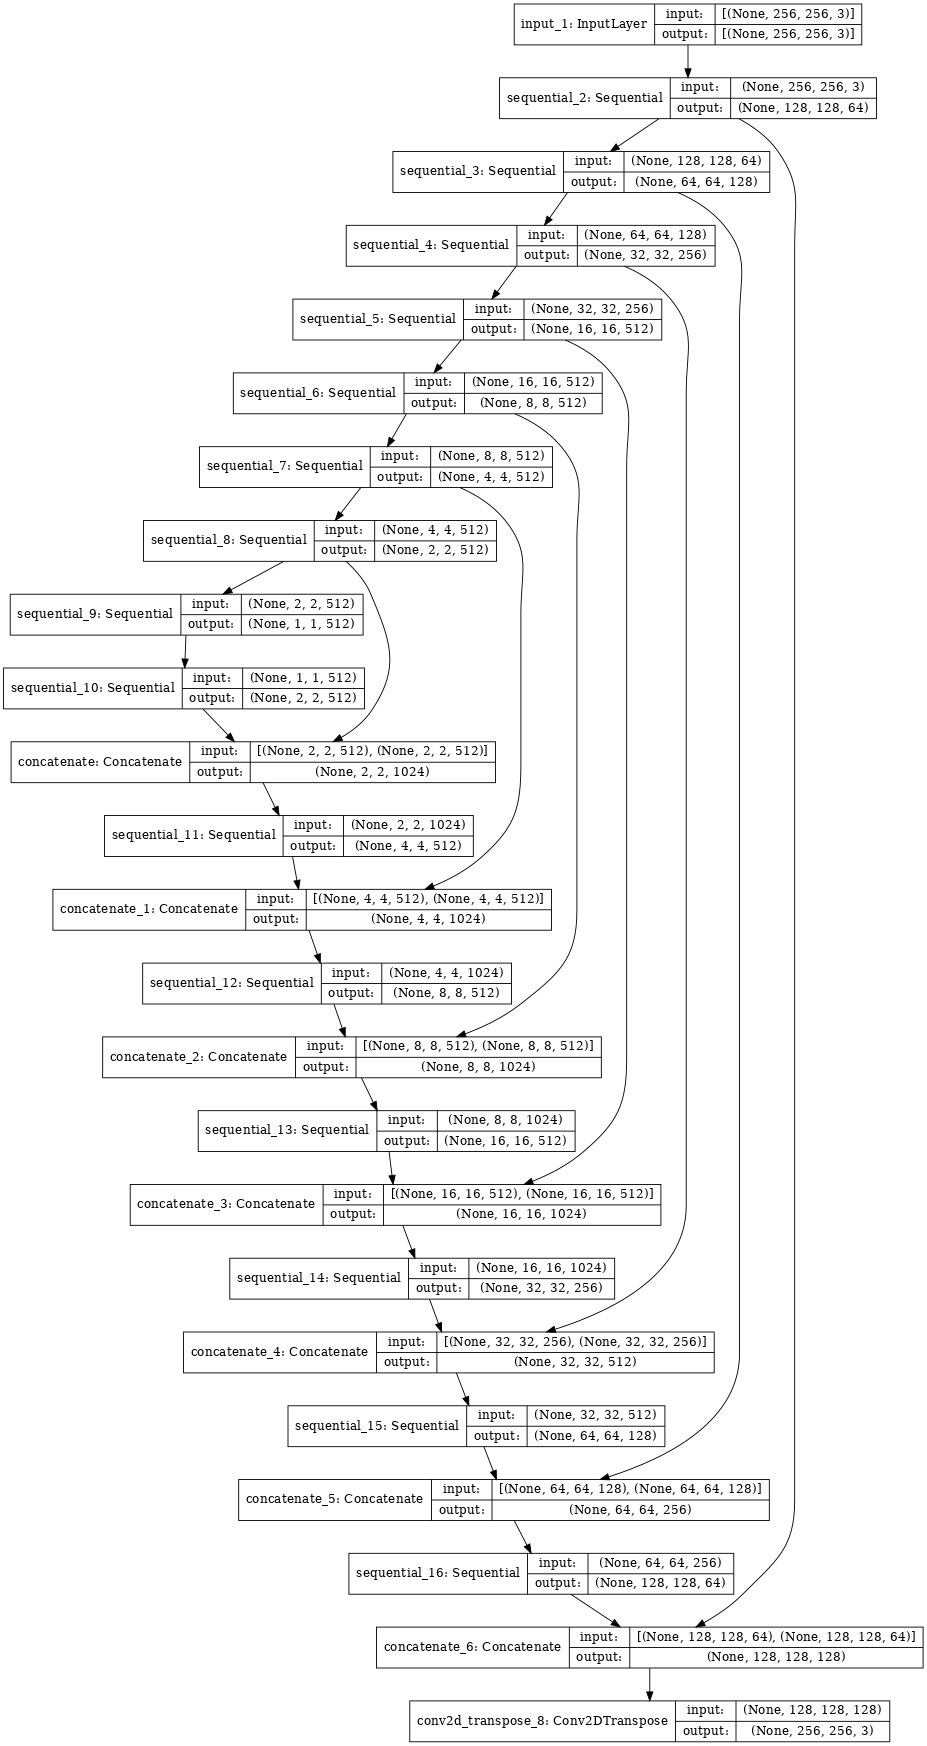

In [47]:
generator = Generator()
tf.keras.utils.plot_model(generator, show_shapes=True, dpi=64)

Test the generator:

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


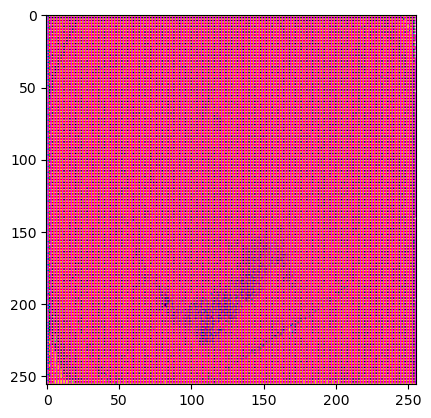

In [48]:
gen_output = generator(inp_res[tf.newaxis, ...], training=False)
plt.imshow(gen_output[0, ...])

### Define the generator loss

GANs learn a loss that adapts to the data, while cGANs learn a structured loss that penalizes a possible structure that differs from the network output and the target image, as described in the [pix2pix paper](https://arxiv.org/abs/1611.07004){:.external}.

- The generator loss is a sigmoid cross-entropy loss of the generated images and an **array of ones**.
- The pix2pix paper also mentions the L1 loss, which is a MAE (mean absolute error) between the generated image and the target image.
- This allows the generated image to become structurally similar to the target image.
- The formula to calculate the total generator loss is `gan_loss + LAMBDA * l1_loss`, where `LAMBDA = 100`. This value was decided by the authors of the paper.

In [49]:
loss_object = tf.keras.losses.BinaryCrossentropy(from_logits=True)

In [50]:
def generator_loss(disc_generated_output, gen_output, target):
    gan_loss = loss_object(tf.ones_like(disc_generated_output), disc_generated_output)

    # Mean absolute error
    l1_loss = tf.reduce_mean(tf.abs(target - gen_output))

    total_gen_loss = gan_loss + (LAMBDA * l1_loss)

    return total_gen_loss, gan_loss, l1_loss

The training procedure for the generator is as follows:

![Generator Update Image](https://github.com/tensorflow/docs/blob/master/site/en/tutorials/generative/images/gen.png?raw=1)


## Build the discriminator

The discriminator in the pix2pix cGAN is a convolutional PatchGAN classifier—it tries to classify if each image _patch_ is real or not real, as described in the [pix2pix paper](https://arxiv.org/abs/1611.07004){:.external}.

- Each block in the discriminator is: Convolution -> Batch normalization -> Leaky ReLU.
- The shape of the output after the last layer is `(batch_size, 30, 30, 1)`.
- Each `30 x 30` image patch of the output classifies a `70 x 70` portion of the input image.
- The discriminator receives 2 inputs: 
    - The input image and the target image, which it should classify as real.
    - The input image and the generated image (the output of the generator), which it should classify as fake.
    - Use `tf.concat([inp, tar], axis=-1)` to concatenate these 2 inputs together.

Let's define the discriminator:

In [51]:
def Discriminator():
    initializer = tf.random_normal_initializer(0., 0.02)

    inp = tf.keras.layers.Input(shape=[image_size, image_size, 3], name='input_image')
    tar = tf.keras.layers.Input(shape=[image_size, image_size, 3], name='target_image')

    x = tf.keras.layers.concatenate([inp, tar])  

    down1 = downsample(64, 4, False)(x) 
    down2 = downsample(128, 4)(down1) 
    down3 = downsample(256, 4)(down2) 

    zero_pad1 = tf.keras.layers.ZeroPadding2D()(down3)  
    conv = tf.keras.layers.Conv2D(512, 4, strides=1,
                                kernel_initializer=initializer,
                                use_bias=False)(zero_pad1)  
    
    batchnorm1 = tf.keras.layers.BatchNormalization()(conv)
    leaky_relu = tf.keras.layers.LeakyReLU()(batchnorm1)
    zero_pad2 = tf.keras.layers.ZeroPadding2D()(leaky_relu)  

    last = tf.keras.layers.Conv2D(1, 4, strides=1,
                                kernel_initializer=initializer)(zero_pad2) 

    return tf.keras.Model(inputs=[inp, tar], outputs=last)

Visualize the discriminator model architecture:

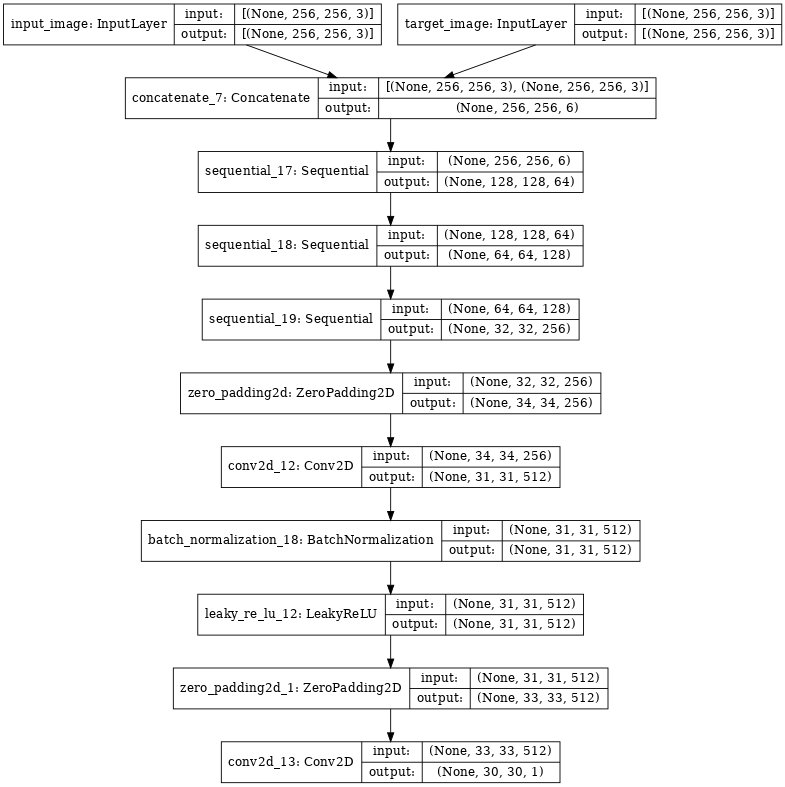

In [52]:
discriminator = Discriminator()
tf.keras.utils.plot_model(discriminator, show_shapes=True, dpi=64)

Test the discriminator:

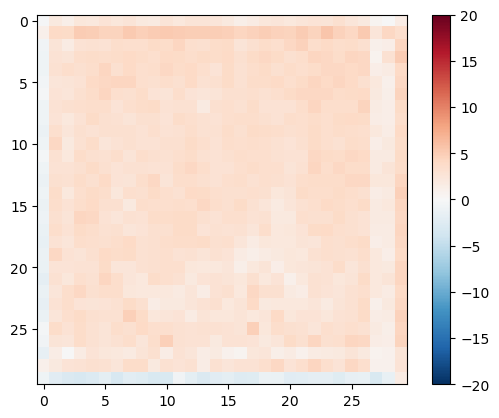

In [53]:
disc_out = discriminator([inp_res[tf.newaxis, ...], gen_output], training=False)
plt.imshow(disc_out[0, ..., -1], vmin=-20, vmax=20, cmap='RdBu_r')
plt.colorbar()

### Define the discriminator loss

- The `discriminator_loss` function takes 2 inputs: **real images** and **generated images**.
- `real_loss` is a sigmoid cross-entropy loss of the **real images** and an **array of ones(since these are the real images)**.
- `generated_loss` is a sigmoid cross-entropy loss of the **generated images** and an **array of zeros (since these are the fake images)**.
- The `total_loss` is the sum of `real_loss` and `generated_loss`.

In [54]:
def discriminator_loss(disc_real_output, disc_generated_output):
    real_loss = loss_object(tf.ones_like(disc_real_output), disc_real_output)

    generated_loss = loss_object(tf.zeros_like(disc_generated_output), disc_generated_output)

    total_disc_loss = real_loss + generated_loss

    return total_disc_loss

The training procedure for the discriminator is shown below.

To learn more about the architecture and the hyperparameters you can refer to the [pix2pix paper](https://arxiv.org/abs/1611.07004){:.external}.

![Discriminator Update Image](https://github.com/tensorflow/docs/blob/master/site/en/tutorials/generative/images/dis.png?raw=1)


## Define the optimizers and a checkpoint-saver


In [55]:
generator_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)
discriminator_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)

In [56]:
checkpoint_dir = workspace_path + 'training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(generator_optimizer=generator_optimizer,
                                 discriminator_optimizer=discriminator_optimizer,
                                 generator=generator,
                                 discriminator=discriminator)

## Generate images

Write a function to plot some images during training.

- Pass images from the test set to the generator.
- The generator will then translate the input image into the output.
- The last step is to plot the predictions and _voila_!

Note: The `training=True` is intentional here since you want the batch statistics, while running the model on the test dataset. If you use `training=False`, you get the accumulated statistics learned from the training dataset (which you don't want).

In [75]:
def generate_images(epoch,model,test_input,tar,imgi,display_imgs=True, save_path=results_path, ts_path=test_path):
    prediction = model(test_input, training=True)
    test_names = glob.glob(ts_path + '*.jpg')
    save_filenames = test_names[imgi*BATCH_SIZE:(imgi+1)*BATCH_SIZE]
    for ind in range(0, 5):
        tf.keras.preprocessing.image.save_img(save_path + save_filenames[ind].split('/')[-1].split('.')[0]+ '_segmentation' + '_'+str(epoch)+'_generation.png',prediction[ind])
        if display_imgs:
            display_list = [test_input[ind], tar[ind], prediction[ind]]
            title = ['Input Image', 'Ground Truth', 'Predicted Image']

            for i in range(3):
                plt.subplot(1, 3, i+1)
                plt.title(title[i])
                # Getting the pixel values in the [0, 1] range to plot.
                plt.imshow(display_list[i] * 0.5 + 0.5)
                plt.axis('off')
            plt.savefig(results_path + save_filenames[0].split('/')[-1].split('.')[0]+'_'+str(epoch))
        plt.show()

Test the function:

## Training

- For each example input generates an output.
- The discriminator receives the `input_image` and the generated image as the first input. The second input is the `input_image` and the `target_image`.
- Next, calculate the generator and the discriminator loss.
- Then, calculate the gradients of loss with respect to both the generator and the discriminator variables(inputs) and apply those to the optimizer.
- Finally, log the losses to TensorBoard.

In [58]:
log_dir="logs/"

summary_writer = tf.summary.create_file_writer(
  log_dir + "fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))

In [61]:
def get_jaccard(epoch):
    
    mask_original=[]
    mask_predict =[]
    iou=[]
    
    seg_path = test_path+'segmentation/'
    seg_names = os.listdir(seg_path)
    for idx, filename in enumerate(seg_names):
        
        map_image = plt.imread(results_path+filename.split('.')[0]+'_'+str(epoch)+'_generation.png')
        os.remove(results_path+filename.split('.')[0]+'_'+str(epoch)+'_generation.png')
        map_image = cv2.cvtColor(map_image, cv2.COLOR_RGB2GRAY)
        map_image_real = plt.imread(seg_path + filename)
        map_image_real = cv2.resize(map_image_real, (image_size, image_size), interpolation = cv2.INTER_AREA)
        
        mask_predict.append(map_image > 0)
        mask_original.append(map_image_real > 0)
         
        img_true=np.array(mask_original).ravel()
        img_pred=np.array(mask_predict).ravel()

        score = jaccard_score(img_true, img_pred)
        print('get_jaccard at epoch: ', epoch, ' score: ', score)
        iou.append(score)
    return iou

In [62]:
@tf.function
def train_step(input_image, target):
    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        gen_output = generator(input_image, training=True)

        disc_real_output = discriminator([input_image, target], training=True)
        disc_generated_output = discriminator([input_image, gen_output], training=True)

        gen_total_loss, gen_gan_loss, gen_l1_loss = generator_loss(disc_generated_output, gen_output, target)
        disc_loss = discriminator_loss(disc_real_output, disc_generated_output)

        generator_gradients = gen_tape.gradient(gen_total_loss,
                                              generator.trainable_variables)
        discriminator_gradients = disc_tape.gradient(disc_loss,
                                                   discriminator.trainable_variables)

        generator_optimizer.apply_gradients(zip(generator_gradients,
                                              generator.trainable_variables))
        discriminator_optimizer.apply_gradients(zip(discriminator_gradients,
                                                  discriminator.trainable_variables))

In [63]:
tf.config.run_functions_eagerly(True)

Calculating Jaccard Score

In [64]:
from IPython.display import clear_output

jaccard_index_total =[]

def fit(train_ds, test_ds, epochs):
    for epoch in range(epochs):
        imgi = 0
        start = time.time()
        print('epoch#: ', epoch)
        for in_img, tr in tqdm(train_ds):
            train_step(in_img, tr)
        
        imgi=0
        predictions = []
        for inp, tar in test_ds:
            generate_images(epoch,generator, inp, tar,imgi, display_imgs = False)
            imgi+=1
        if epoch % 10 == 0:
            jaccard_index_total.append(get_jaccard(epoch))
        if (epoch +1)% 25 == 0:
            checkpoint.save(file_prefix=checkpoint_prefix)
        clear_output(wait=True)

This training loop saves logs that you can view in TensorBoard to monitor the training progress.

If you work on a local machine, you would launch a separate TensorBoard process. When working in a notebook, launch the viewer before starting the training to monitor with TensorBoard.

To launch the viewer paste the following into a code-cell:

In [65]:
plt.rcParams['figure.figsize'] = [10,8]

##### Finally, run the training loop:

In [66]:
!export LD_LIBRARY_PATH=$LD_LIBRARY_PATH:$CONDA_PREFIX/lib/

/bin/bash: /home/ahmedf/anaconda3/envs/skin_deep/lib/python3.9/site-packages/cv2/../../../../lib/libtinfo.so.6: no version information available (required by /bin/bash)


In [67]:
physical_devices = tf.config.list_physical_devices('GPU')
try:
  tf.config.experimental.set_memory_growth(physical_devices[0], True)
except:
  # Invalid device or cannot modify virtual devices once initialized.
  pass

In [47]:
with tf.device('/device:GPU:0'):
    fit(train_dataset, test_dataset, epochs=200)

epoch#:  0


  0%|                                                                                                                                                       | 0/9 [00:00<?, ?it/s]2022-12-05 22:19:12.791470: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:116] None of the MLIR optimization passes are enabled (registered 2)
2022-12-05 22:19:12.814886: I tensorflow/core/platform/profile_utils/cpu_utils.cc:112] CPU Frequency: 3699850000 Hz
2022-12-05 22:19:26.056471: W tensorflow/core/common_runtime/bfc_allocator.cc:248] Allocator (GPU_0_bfc) ran out of memory trying to allocate 3.77GiB with freed_by_count=0. The caller indicates that this is not a failure, but may mean that there could be performance gains if more memory were available.
2022-12-05 22:19:26.102900: W tensorflow/core/common_runtime/bfc_allocator.cc:248] Allocator (GPU_0_bfc) ran out of memory trying to allocate 748.05MiB with freed_by_count=0. The caller indicates that this is not a failure, but may mean that ther

  0%|                                                                                                                                                       | 0/9 [00:23<?, ?it/s]
2022-12-05 22:19:36.367314: I tensorflow/core/common_runtime/bfc_allocator.cc:1028] InUse at 7fa1d1efb100 of size 492032 next 317
2022-12-05 22:19:36.367326: I tensorflow/core/common_runtime/bfc_allocator.cc:1028] InUse at 7fa1d1f73300 of size 492032 next 321
2022-12-05 22:19:36.367337: I tensorflow/core/common_runtime/bfc_allocator.cc:1028] InUse at 7fa1d1feb500 of size 492032 next 322
2022-12-05 22:19:36.367349: I tensorflow/core/common_runtime/bfc_allocator.cc:1028] InUse at 7fa1d2063700 of size 492032 next 324
2022-12-05 22:19:36.367361: I tensorflow/core/common_runtime/bfc_allocator.cc:1028] InUse at 7fa1d20db900 of size 492032 next 325
2022-12-05 22:19:36.367372: I tensorflow/core/common_runtime/bfc_allocator.cc:1028] Free  at 7fa1d2153b00 of size 492032 next 326
2022-12-05 22:19:36.367384: I tensorflow/

2022-12-05 22:19:36.368144: I tensorflow/core/common_runtime/bfc_allocator.cc:1036] 1 Chunks of size 32768 totalling 32.0KiB
2022-12-05 22:19:36.368158: I tensorflow/core/common_runtime/bfc_allocator.cc:1036] 2 Chunks of size 123136 totalling 240.5KiB
2022-12-05 22:19:36.368171: I tensorflow/core/common_runtime/bfc_allocator.cc:1036] 1 Chunks of size 167424 totalling 163.5KiB
2022-12-05 22:19:36.368185: I tensorflow/core/common_runtime/bfc_allocator.cc:1036] 2 Chunks of size 262144 totalling 512.0KiB
2022-12-05 22:19:36.368198: I tensorflow/core/common_runtime/bfc_allocator.cc:1036] 1 Chunks of size 458752 totalling 448.0KiB
2022-12-05 22:19:36.368212: I tensorflow/core/common_runtime/bfc_allocator.cc:1036] 29 Chunks of size 492032 totalling 13.61MiB
2022-12-05 22:19:36.368225: I tensorflow/core/common_runtime/bfc_allocator.cc:1036] 2 Chunks of size 524288 totalling 1.00MiB
2022-12-05 22:19:36.368239: I tensorflow/core/common_runtime/bfc_allocator.cc:1036] 1 Chunks of size 786432 total

ResourceExhaustedError: OOM when allocating tensor with shape[32,512,512,3] and type float on /job:localhost/replica:0/task:0/device:GPU:0 by allocator GPU_0_bfc [Op:Tile]

In [68]:
plt.rcParams['figure.figsize'] = [60,8.5]
jaccard_index_total_aux = jaccard_index_total.copy()
n = 2667 # total training and test 
np.save('jaccard_index_PATCHGAN'+'_'+str(BATCH_SIZE)+'_'+str(n)+'_XD.npy',jaccard_index_total_aux)

In [69]:
jaccard_atribute = []

for jaccard_by_epoch in jaccard_index_total:
    jaccard_atribute.append(jaccard_by_epoch)

In [70]:
for idx,jaccard_idx in enumerate(jaccard_atribute):
    fig = plt.figure(figsize=(50,20))
    n_epochs = 100
    jaccard_idx = jaccard_idx[0:100]
    plt.scatter(range(0,n_epochs),jaccard_idx)
    
    from scipy.ndimage.filters import gaussian_filter1d
    ysmoothed = gaussian_filter1d(jaccard_idx, sigma=2)
    plt.plot(range(0,n_epochs),ysmoothed,"r--")

    
    plt.xlabel('epochs', fontsize=40)
    plt.ylabel('jaccard index', fontsize=40)
    maxi = str(round(np.max(jaccard_idx),5))
    plt.legend(['max: '+maxi],fontsize=40)
    plt.show()
    fig.savefig(results_path+'jaccard_graph.jpg')

## Restore the latest checkpoint and test the network

In [71]:
!ls {checkpoint_dir}

/bin/bash: /home/ahmedf/anaconda3/envs/skin_deep/lib/python3.9/site-packages/cv2/../../../../lib/libtinfo.so.6: no version information available (required by /bin/bash)
checkpoint		     ckpt-2.index
ckpt-10.data-00000-of-00001  ckpt-3.data-00000-of-00001
ckpt-10.index		     ckpt-3.index
ckpt-11.data-00000-of-00001  ckpt-4.data-00000-of-00001
ckpt-11.index		     ckpt-4.index
ckpt-12.data-00000-of-00001  ckpt-5.data-00000-of-00001
ckpt-12.index		     ckpt-5.index
ckpt-13.data-00000-of-00001  ckpt-6.data-00000-of-00001
ckpt-13.index		     ckpt-6.index
ckpt-14.data-00000-of-00001  ckpt-7.data-00000-of-00001
ckpt-14.index		     ckpt-7.index
ckpt-15.data-00000-of-00001  ckpt-8.data-00000-of-00001
ckpt-15.index		     ckpt-8.index
ckpt-1.data-00000-of-00001   ckpt-9.data-00000-of-00001
ckpt-1.index		     ckpt-9.index
ckpt-2.data-00000-of-00001


### Restoring the latest checkpoint in checkpoint_dir

In [72]:
checkpoint.restore(tf.train.latest_checkpoint(checkpoint_dir))

/content/logs

## Generate some images using the test set

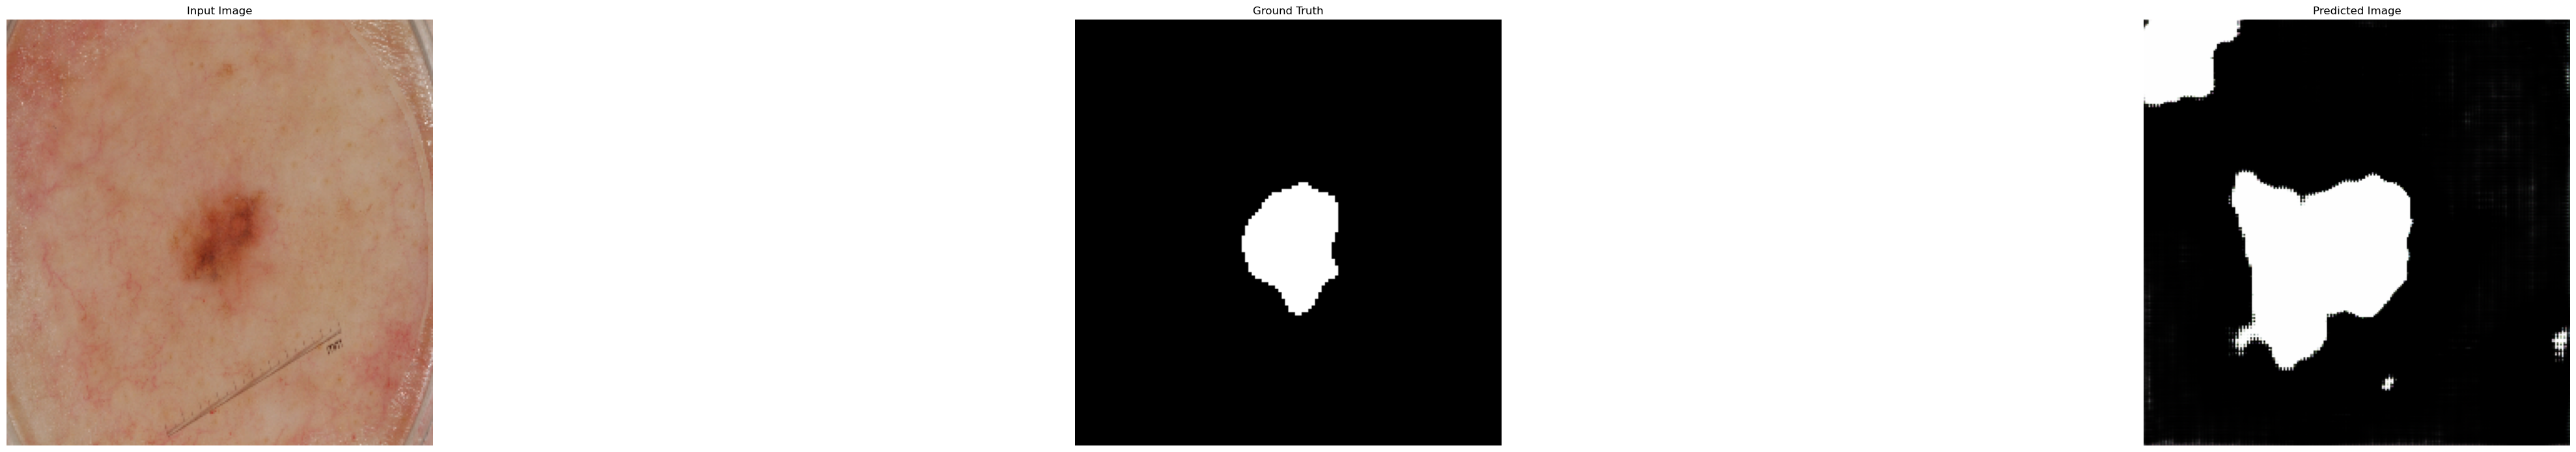

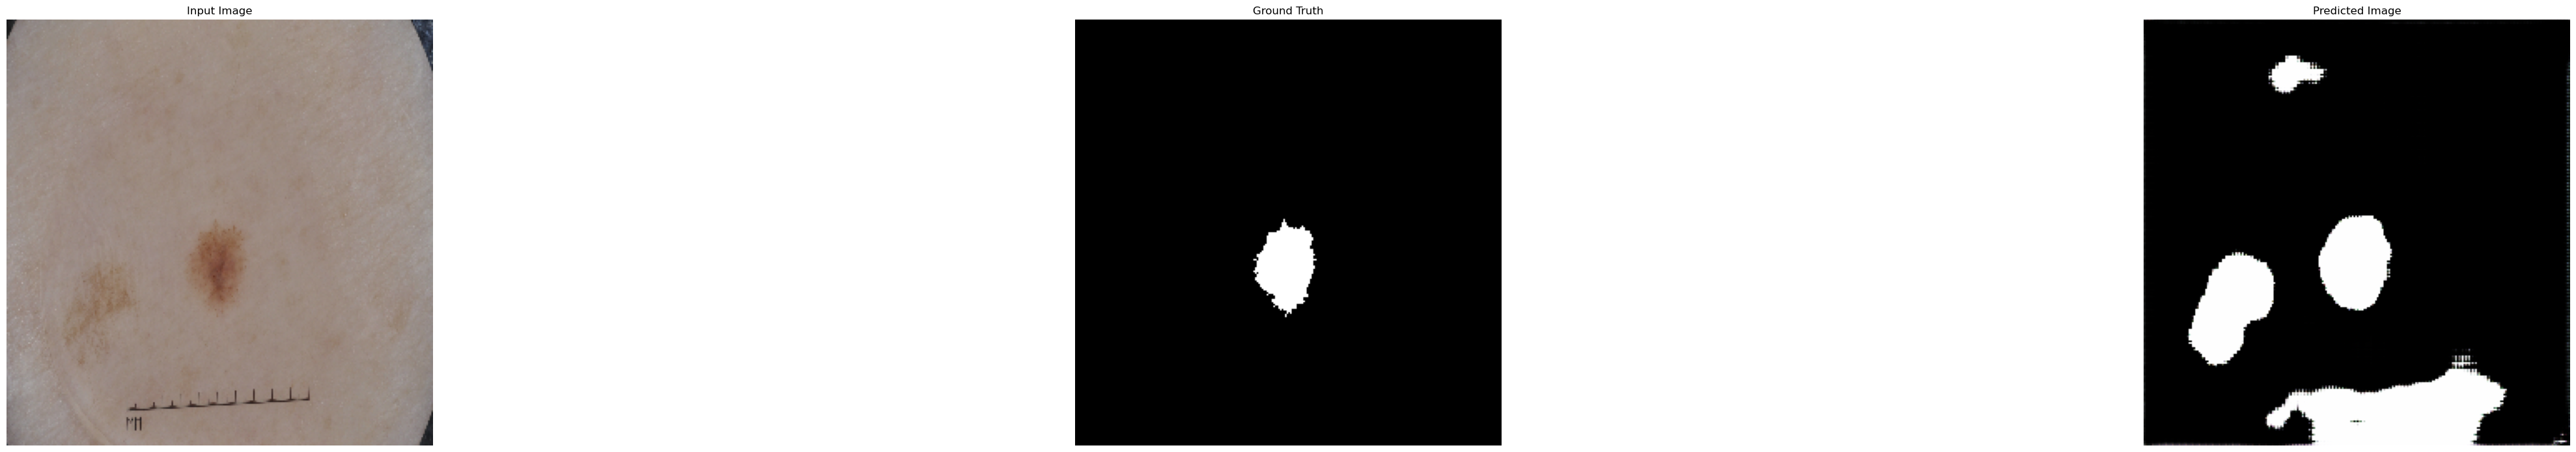

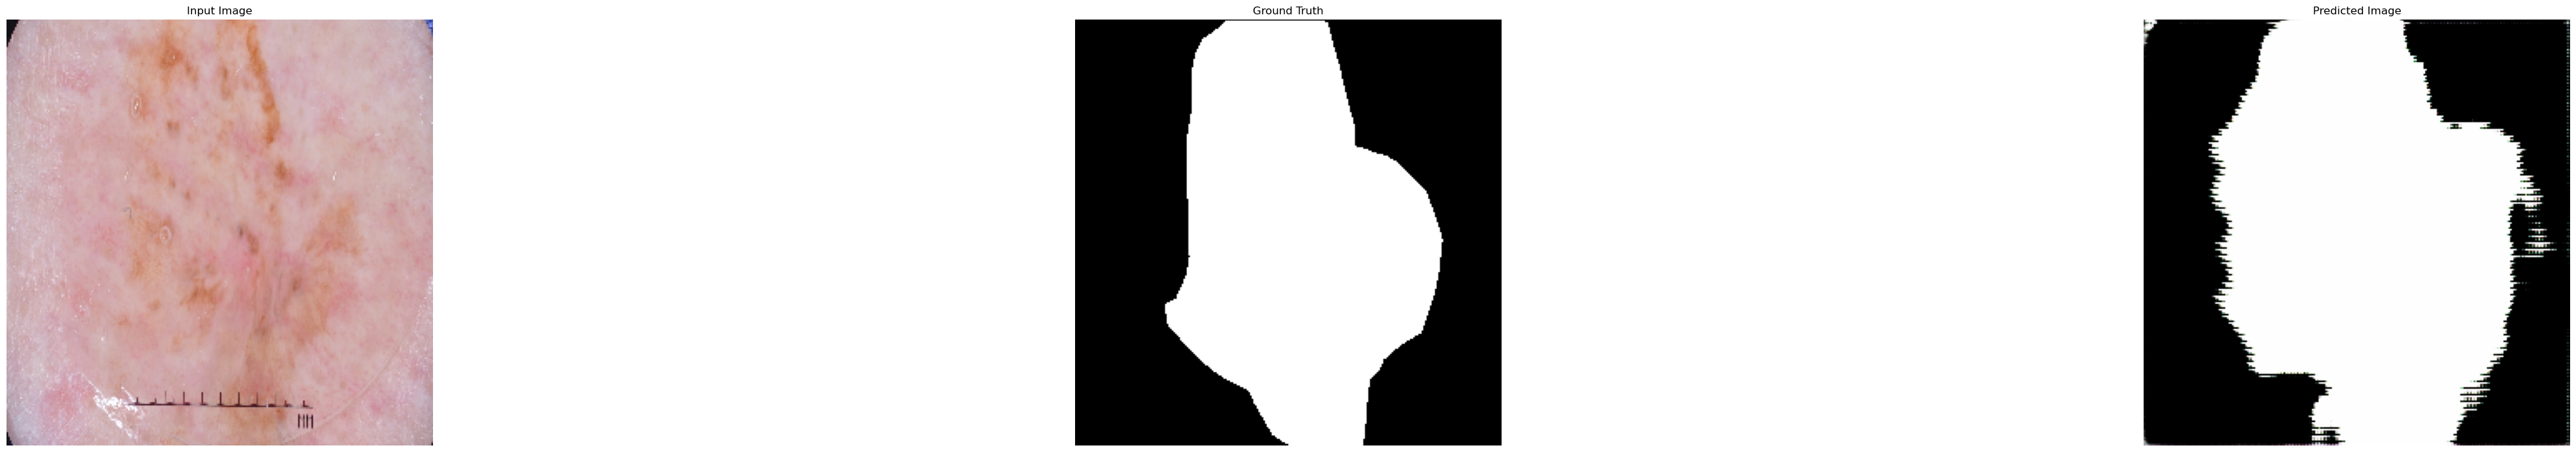

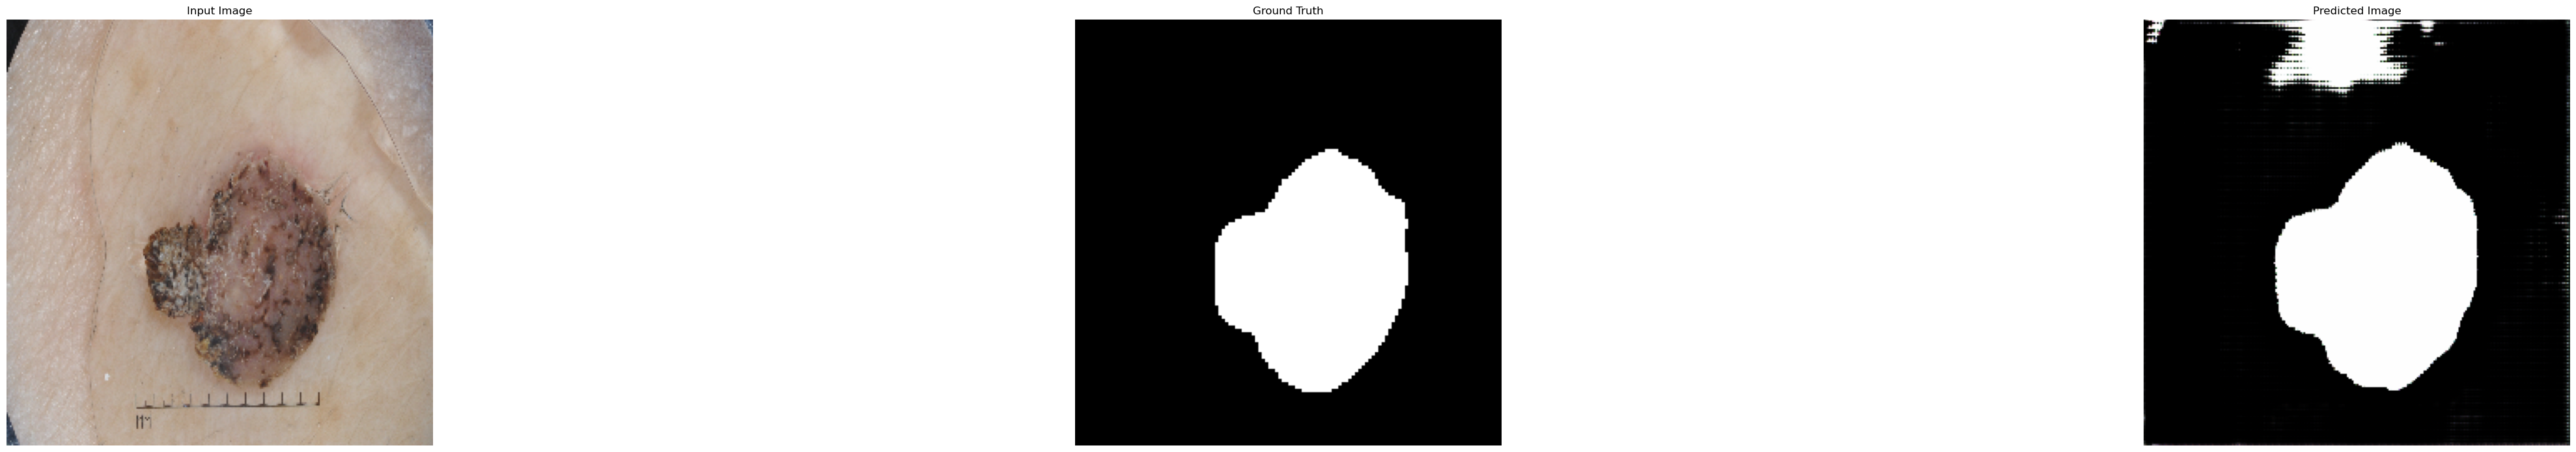

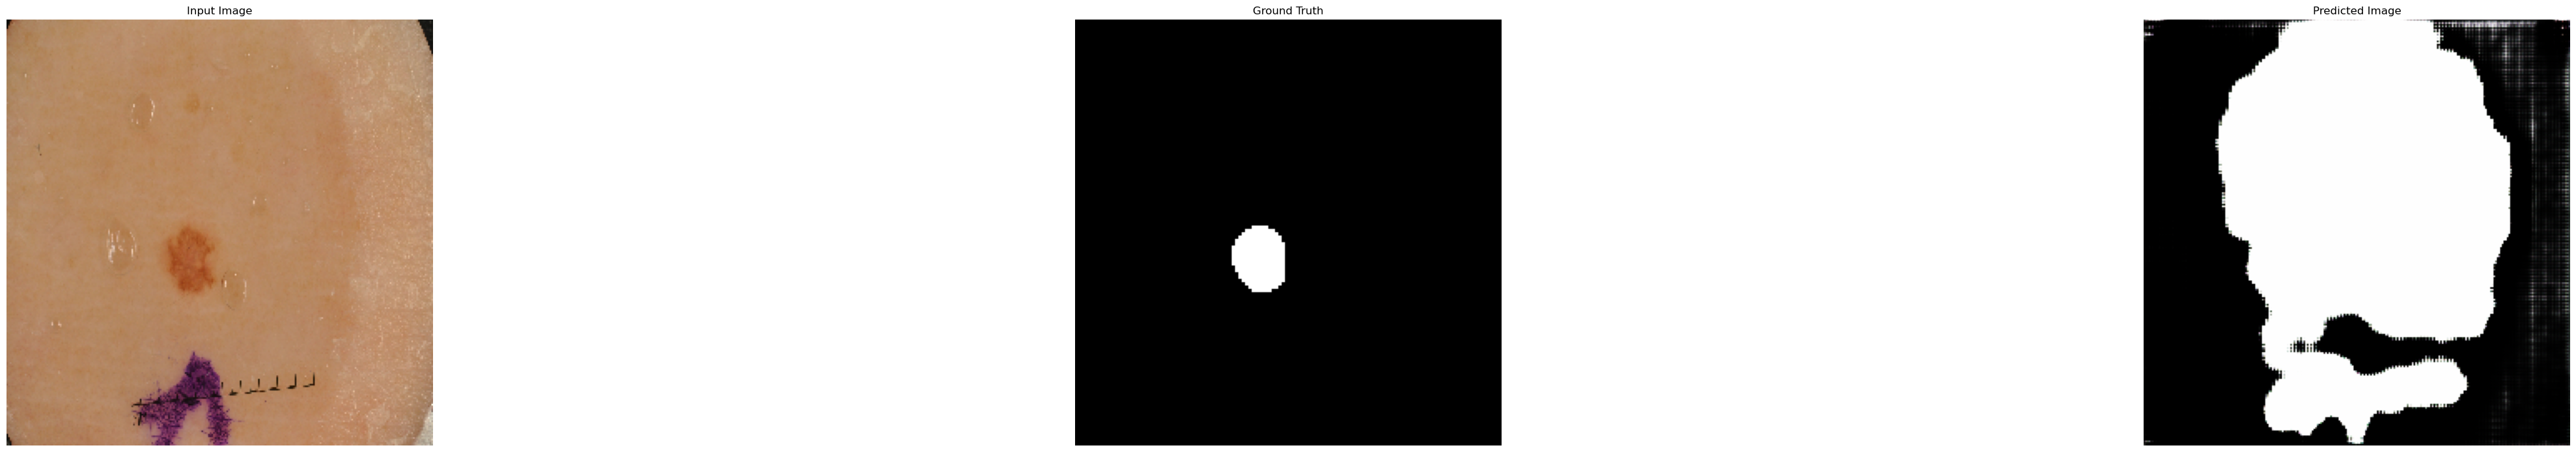

In [76]:
# Run the trained model on a few examples from the test set
for inp, tar in test_dataset.take(1):
    generate_images(1, generator, inp, tar, 2, display_imgs=True) 